# Stochastic Thermostats

Test System
-----------

We will test the effectiveness of different thermostats on a set of decoupled harmonic oscillators. For this system, thermal expectation values and time-correlation functions under the action of a (generalised) Langevin thermostat can be calculated analytically. The frequencies of our oscillators are taken from the 12-mode discretization of the exponentially damped Ohmic spectral density with a cut-off $\omega_{\text{c}} = 500~\text{cm}^{-1}$, spanning values from $21~\text{cm}^{-1}$ to $1589~\text{cm}^{-1}$:
$$
\omega_i = -\omega_{\text{c}} \log\left(
    \frac{i - 1/2}{n_{\text{bath}}}
\right) \qquad i = 1,\ldots,n_{\text{bath}}.
$$
We'll be looking at a temperature of 300 K and set the masses of all the oscillators to the mass of the proton.

Langevin Themostat
------------------

There is only one parameter that can be tuned, the friction coefficient $\gamma$ or, equivalently, its reciprocal $\tau = 1/\gamma$.
For a harmonic oscillator with frequency $\omega$, mass $m$, and equilibrum centred at the origin, the position auto-correlation function at a temperature $T$ is
$$
\left\langle x(0) x(t)\right\rangle = 
\frac{
    \mathrm{e}^{-t / 2 \tau}
}{
    \beta m \omega^2
} \times 
\begin{cases}
    \cos(\Omega t) + \frac{1}{2\Omega\tau} \sin(\Omega t) &  \tau > \frac{1}{2 \omega} \\
    \cosh(\Omega t) + \frac{1}{2 \Omega \tau} \sinh( \Omega t) &  \tau < \frac{1}{2 \omega} \\
    1 + \frac{t}{2 \tau} &  \tau = \frac{1}{2 \omega}
\end{cases}
$$
where $\Omega = \sqrt{ |\omega^2 - (1/2 \tau)^2 | } \text{ and } \beta = 1/k_{\text{B}}T$. One metric that was used to test thermostatting efficiency by Ceriotti et al. in _J. Chem. Phys._ **133**, 124104, (2010) is the potential-energy autocorrelation function, for which we need
$$
\left\langle x(0)^2 x(t)^2 \right\rangle = 2 \left\langle x(0) x(t) \right\rangle^2 + \left\langle x^2 \right\rangle^2.
$$
that we can compute from [Isserlis' theorem](https://en.wikipedia.org/wiki/Isserlis%27_theorem). The fastest decorrelation time is achieved for $\tau = 1/\omega$. When $\tau$ is *large*, the system is underdamped and the decay timescale asymptotically tends to $\tau$. At the other extreme, the decay time becomes arbitrarily long for a sufficiently *small* $\tau$, so it is better to be underdamped.

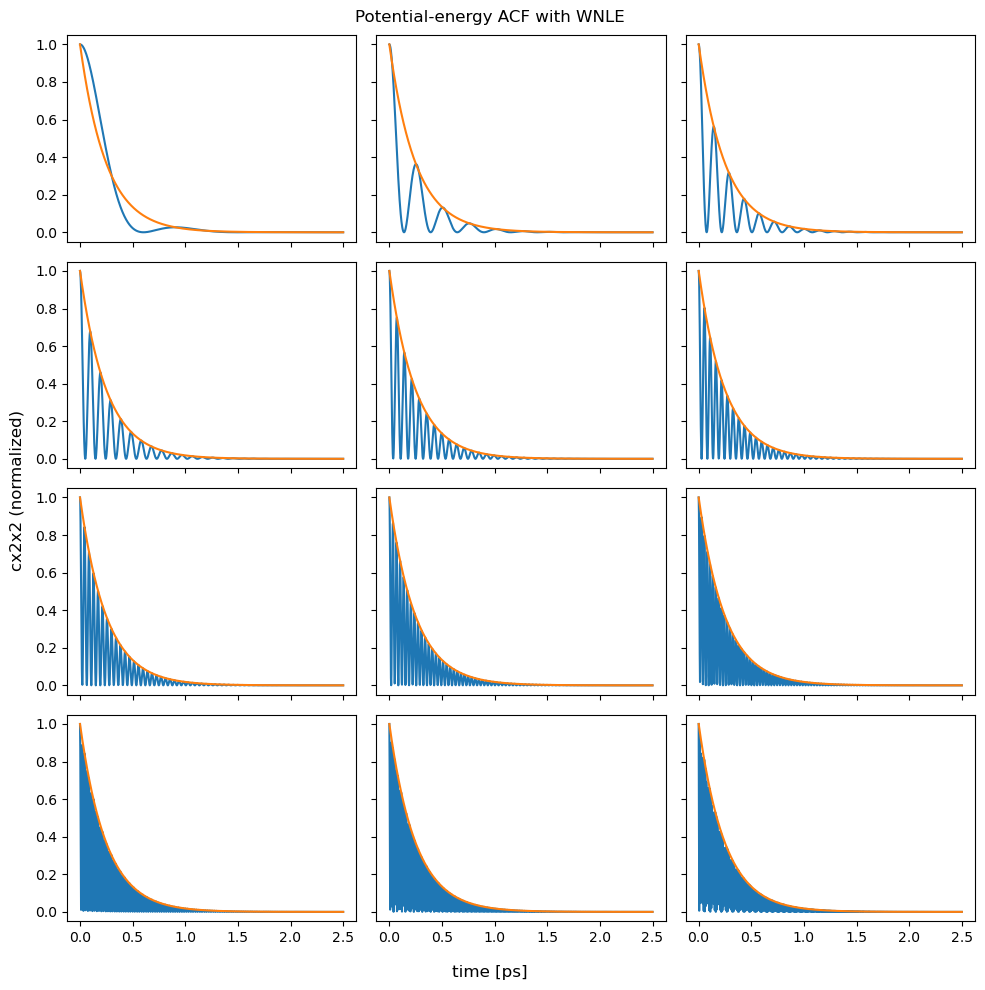

In [31]:
from tools import units, gle, baths
import matplotlib.pyplot as plt
import numpy as np

# Setting up the test system
u = units.atomic()
T = 300.0 
beta = u.betaTemp(T)
nbath = 12
wc = u.wn2omega(500.0)      # frequency cut-off 500 cm^-1
mass = u.str2base("1 mp") # proton mass in system units
layout = (4,3)            # plotting layout
bath = baths.ExpOhmic(mass, nbath, 1.0, wc)
freqs = bath.frequencies
# Analytical results for potential/kinetic energies and their squares
x2avg = []
p2avg = []
gamma = np.min(freqs)
tau = 1/gamma
for freq in freqs:
    x2, p2 = np.diag(gle.gle_cxx(0.0, beta, freq, tau, mass=mass)[0])
    x2avg.append(x2)
    p2avg.append(p2)
x2avg = np.asarray(x2avg)
p2avg = np.asarray(p2avg)
x4avg = 3*x2avg**2
p4avg = 3*p2avg**2

# Plotting the TCF
tmax = 2.5 # ps
npts = 1000
t_ps = np.linspace(0, tmax, npts)
t = t_ps * u.str2base("1 ps")  # in internal units
r, c = layout
fig, axarr = plt.subplots(nrows=r, ncols=c, sharex=True, sharey=True)
fig.set_size_inches([10, 10])
for i, ax in enumerate(np.ravel(axarr)):
    # Analytical time-correlation function
    ax.plot(t_ps, 
            (2*gle.wnle_cqq(t, beta, freqs[i], tau, mass)**2) / 
            (x4avg[i] - x2avg[i]**2))
    # Envelope
    ax.plot(t_ps, np.exp(-t/tau))
fig.suptitle("Potential-energy ACF with WNLE")
fig.supxlabel("time [ps]");
fig.supylabel("cx2x2 (normalized)");
fig.tight_layout()

## Generalized Langevin Equation thermostat (GLE)

A GLE thermostat is more flexble than white-noise Langeving (WNLE), and can enhance the sampling accuracy of the higher frequency modes affecting too badly the sampling of slow modes. Our example uses a drift matrix from [gle4md.org](gle4md.org) using a *Smart sampling* GLE type with the slowest sampling timescale of 2 ps, number of auxiliary DoFs = 6, and $\omega_{\mathrm{max}} / \omega_{\mathrm{min}} = 100$.

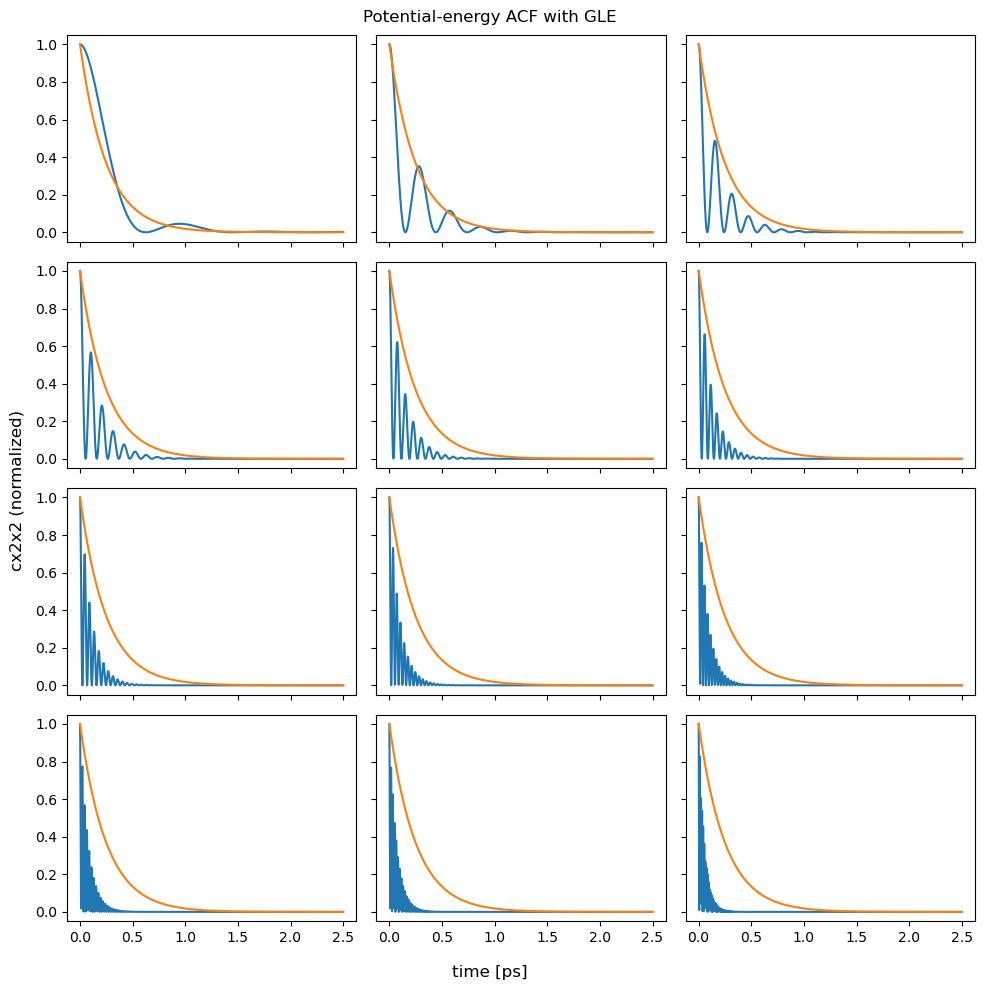

In [30]:
import json

with open("thermostats/gle.json", "r") as f:
    A_pp = np.asarray(json.load(f)["A"])
fig, axarr = plt.subplots(nrows=r, ncols=c, sharex=True, sharey=True)
fig.set_size_inches([10, 10])
for i, ax in enumerate(np.ravel(axarr)):
    ref_tcf = gle.gle_cxx(t, beta, freqs[i], A_pp, mass=mass)
    cxx = ref_tcf[:,0,0]
    ax.plot(t_ps, 2*cxx**2 / (x4avg[i] - x2avg[i]**2))
    ax.plot(t_ps, np.exp(-t/tau))
fig.suptitle("Potential-energy ACF with GLE")
fig.supxlabel("time [ps]");
fig.supylabel("cx2x2 (normalized)");
fig.tight_layout()

## Stochastic velocity rescaling (SVR)

This, essentially, propagates the total kinetic energy according to a stochastic differential equation that preserves the Boltzmann distribution for the *total* kinetic energy. The thermalisation of other collective variables is not guaranteed and will be poor for our highly harmonic test case. For an anharmonic system, a smaller thermostat parameter $\tau$ will generally ensure faster thermalisation.

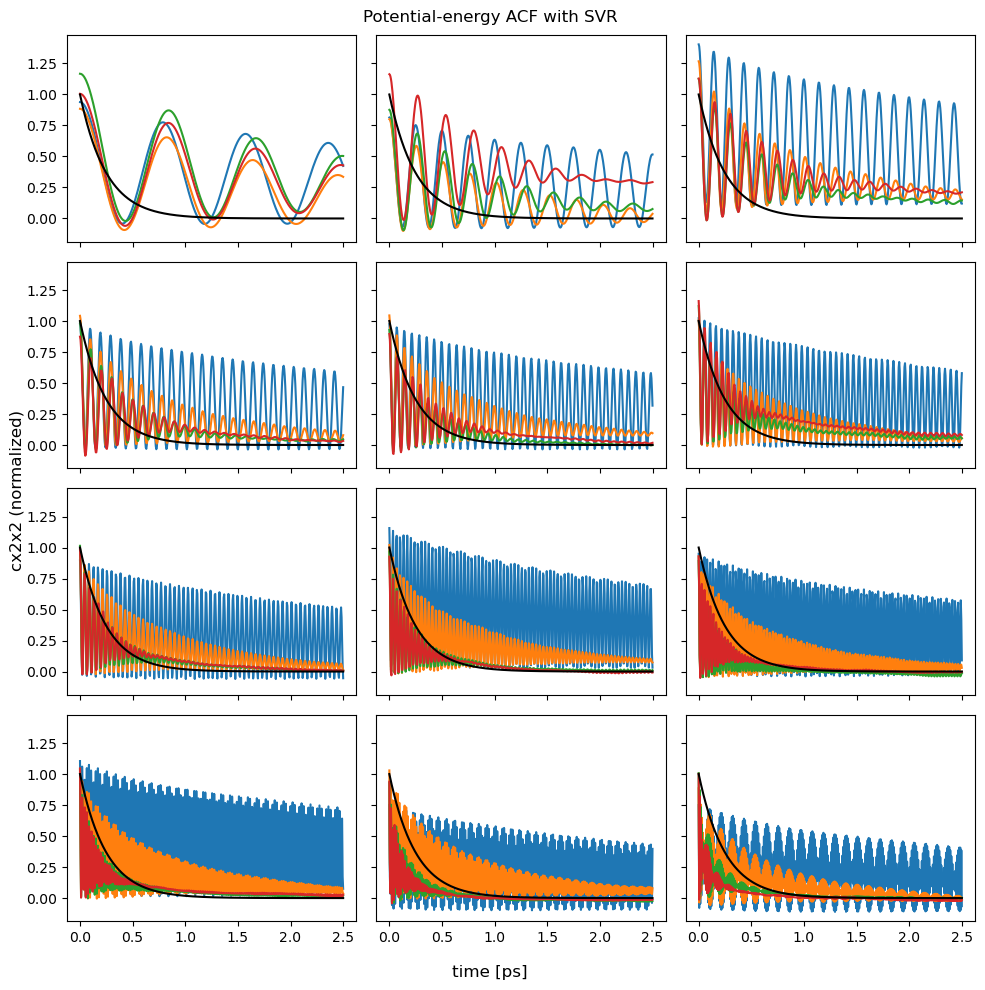

In [29]:
import pandas as pd

fig, axarr = plt.subplots(nrows=r, ncols=c, sharex=True, sharey=True)
fig.set_size_inches([10, 10])
svr_tau = [250, 25, 5, 2]  # thermostat constant in fs
data = []
for datum in svr_tau:
    data.append(pd.read_csv(f'thermostats/svr_{datum:03d}_cx2x2.csv',
                            index_col=0, sep=r'\s+', header=None, skiprows=1))
lines = []
for i, ax in enumerate(np.ravel(axarr)):
    for df in data:
        line, = ax.plot(df.index, (df[2*i+1] - x2avg[i]**2) / (x4avg[i] - x2avg[i]**2))
        if i == 0:
            lines.append(line)
    ax.plot(t_ps, np.exp(-t/tau), c='k')
fig.suptitle("Potential-energy ACF with SVR")
fig.supxlabel("time [ps]");
fig.supylabel("cx2x2 (normalized)");
fig.tight_layout()